# <center>Deep Generative Models</center>
## <center>Seminar 12 </center>

<center>15 May 2025</center>




**Plan**:
1. Basic Understanding of DDPM and DDIM
2. ControlNet for conditional generation
3. IP-Adapter for image-prompted generation
4. LoRA for efficient fine-tuning
5. DreamBooth for personalization

#### 1. Installation and Setup
First, let's install all the necessary dependencies:

In [1]:
# Install required packages
# !pip install -q diffusers==0.25.1 accelerate==0.27.1 peft==0.7.1 transformers==4.36.2 controlnet_aux==0.0.7
# !pip install -q torch==2.1.2 torchvision==0.16.2 xformers==0.0.23.post1
# !pip install -q triton==2.1.0 bitsandbytes==0.41.3 gradio==3.50.2

#### 2. Basic Understanding of Diffusion Models

##### DDPM (Denoising Diffusion Probabilistic Models)

The diffusion process consists of two main parts:
 
1. **Forward Process**: Gradually adds noise to an image until it becomes pure noise
2. **Reverse Process**: Learns to denoise the image step by step

The mathematical formulation for the forward process is:

$q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$

$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t\mathbf{I})$
 
The reverse process tries to learn:

$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$

#### DDIM (Denoising Diffusion Implicit Models)

DDIM is a deterministic variant of DDPM that allows for faster sampling with fewer steps.

**The DDIM sampling formula is:**

$x_{t-1} = \sqrt{\alpha_{t-1}}\left(\frac{x_t - \sqrt{1-\alpha_t}\epsilon_\theta(x_t,t)}{\sqrt{\alpha_t}}\right) + \sqrt{1-\alpha_{t-1}-\sigma_t^2}\epsilon_\theta(x_t,t) + \sigma_t\epsilon$

Where $\sigma_t$ controls the stochasticity (set to 0 for deterministic sampling).

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Load the Stable Diffusion pipeline
def load_sd_model(device="cuda"):
    """Load a Stable Diffusion model with DDIM scheduler"""
    model_id = "runwayml/stable-diffusion-v1-5"
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id, 
        torch_dtype=torch.float32
    )
    pipe.scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
    pipe = pipe.to(device)
    return pipe

# Uncomment to load the model
pipe = load_sd_model()
image = pipe("A photo of a cat sitting on a sofa", num_inference_steps=30).images[0]
image


: 

#### 3. ControlNet

ControlNet allows you to control the diffusion process using conditional inputs like edge maps, depth maps, segmentation maps, etc. It works by:

1. Making a copy of the U-Net encoder blocks
2. Training these blocks to understand the conditioning signal
3. Connecting back to the original model through "zero convolutions"

##### Let's implement ControlNet with a Canny edge detector:

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import ControlNetModel, StableDiffusionControlNetPipeline
from controlnet_aux import CannyDetector

In [3]:
def setup_controlnet():
    """Setup ControlNet with Canny edge detector"""
    # Load ControlNet model
    controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/sd-controlnet-canny",
        torch_dtype=torch.float16
    )
    
    # Create ControlNet pipeline
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=controlnet,
        torch_dtype=torch.float16
    )
    pipe = pipe.to("cuda")
    
    # Initialize the Canny edge detector
    canny_detector = CannyDetector()
    
    return pipe, canny_detector

def generate_with_controlnet(pipe, canny_detector, image_path, prompt):
    """Generate an image using ControlNet with Canny edges"""
    # Load and prepare the conditioning image
    input_image = Image.open(image_path)
    canny_image = canny_detector(input_image, low_threshold=100, high_threshold=200)
    
    # Generate the image
    output_image = pipe(
        prompt=prompt,
        image=canny_image,
        num_inference_steps=30
    ).images[0]
    
    # Display results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(canny_image, cmap='gray')
    axs[1].set_title("Canny Edge Map")
    axs[1].axis('off')
    
    axs[2].imshow(output_image)
    axs[2].set_title("ControlNet Output")
    axs[2].axis('off')
    
    plt.tight_layout()
    return fig

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

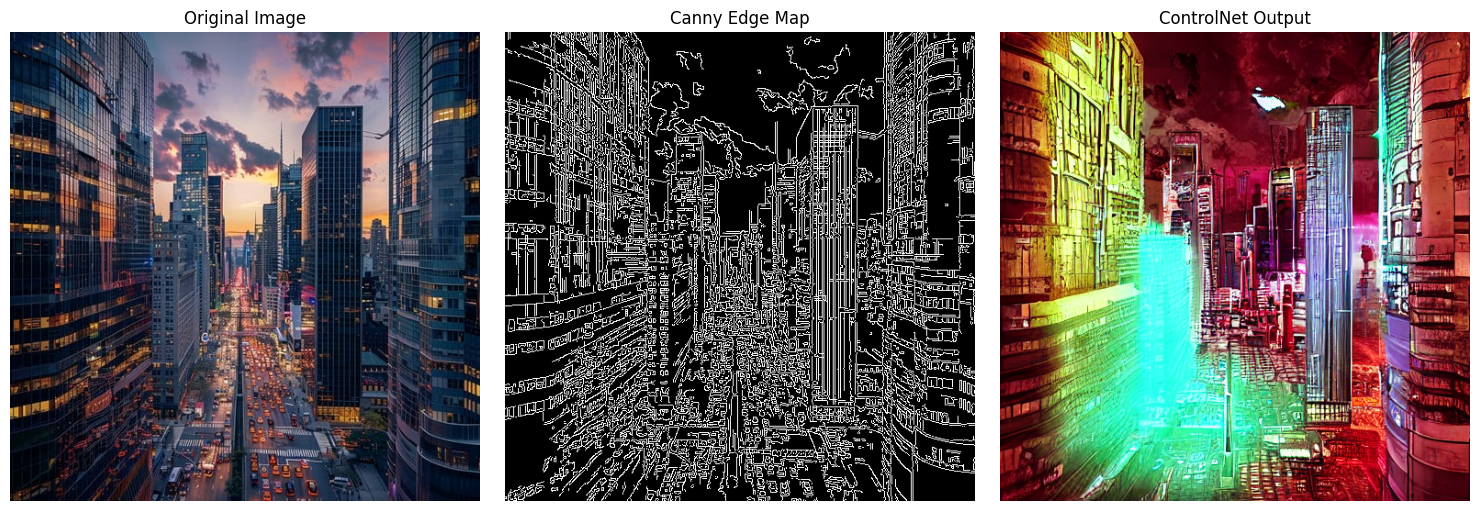

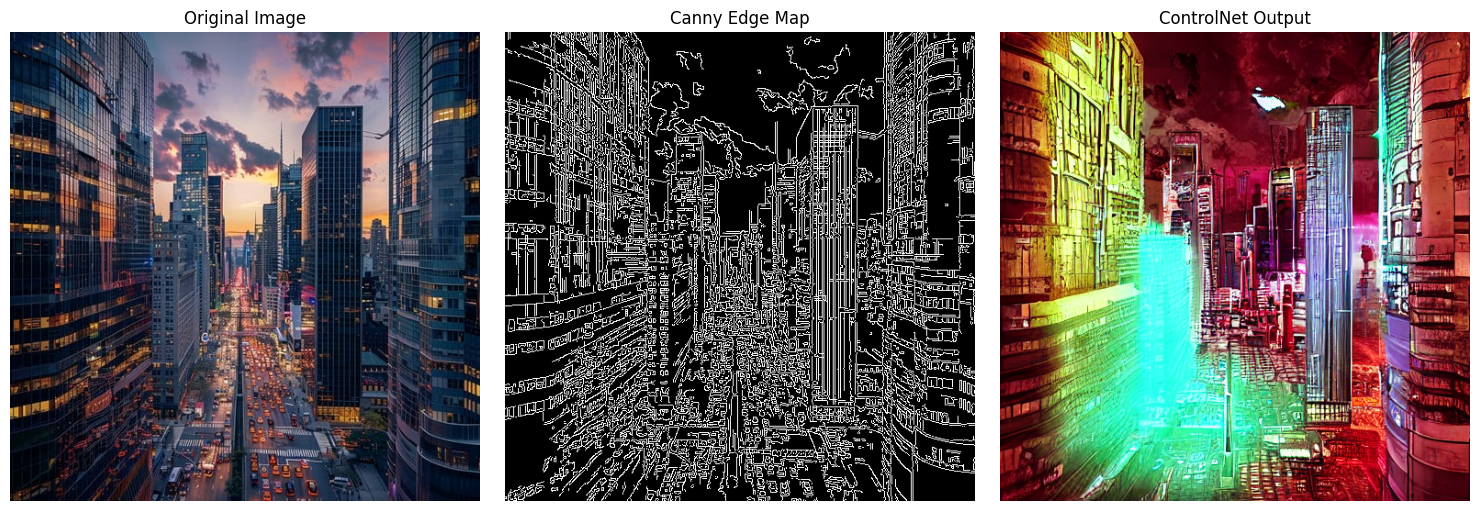

In [ ]:
pipe, canny_detector = setup_controlnet()
generate_with_controlnet(
     pipe, 
     canny_detector,
     "city.jpg",
     "A cyberpunk city landscape"
 )

#### 4. IP-Adapter

IP-Adapter is a method to condition diffusion models using reference images. It works by:

1. Encoding the reference image using a CLIP image encoder
2. Modifying the attention mechanism to incorporate image features

The modified cross-attention mechanism is:

$\text{Attention}(Q,K,V) = \text{Softmax}\left(\frac{QK^T + \lambda QK_{\text{img}}^T}{\sqrt{d}}\right)V$

In [1]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

ImportError: cannot import name 'cached_download' from 'huggingface_hub' (/home/jovyan/.mlspace/envs/dgm/lib/python3.11/site-packages/huggingface_hub/__init__.py)

In [6]:
def setup_ip_adapter():
    """Setup an IP-Adapter with Stable Diffusion"""

    pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16).to("cuda")
    pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
    pipeline.set_ip_adapter_scale(0.6)
    return pipeline

def generate_with_ip_adapter(pipe, reference_image_path, prompt):
    """Generate an image using IP-Adapter with a reference image"""
    # Load reference image
    reference_image = Image.open(reference_image_path).convert("RGB")

    generated_image = pipe(
        prompt=prompt,
        ip_adapter_image=reference_image,
        negative_prompt="deformed, ugly, wrong proportion, low res, worst quality, low quality",
        num_inference_steps=100,
    ).images[0]
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(reference_image)
    axs[0].set_title("Reference Image")
    axs[0].axis('off')
    
    # Placeholder for generated image
    axs[1].imshow(generated_image)
    axs[1].set_title("IP-Adapter Output")
    axs[1].axis('off')
    
    plt.tight_layout()
    return fig

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

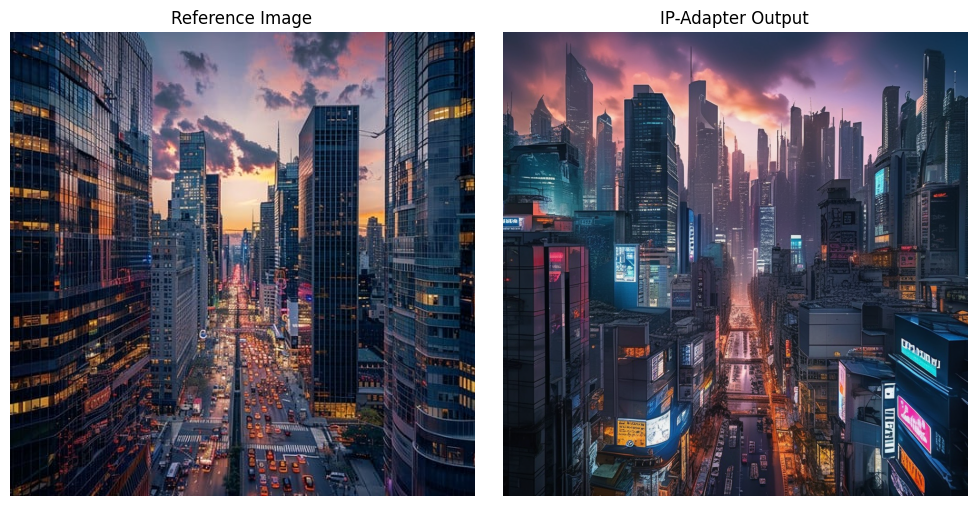

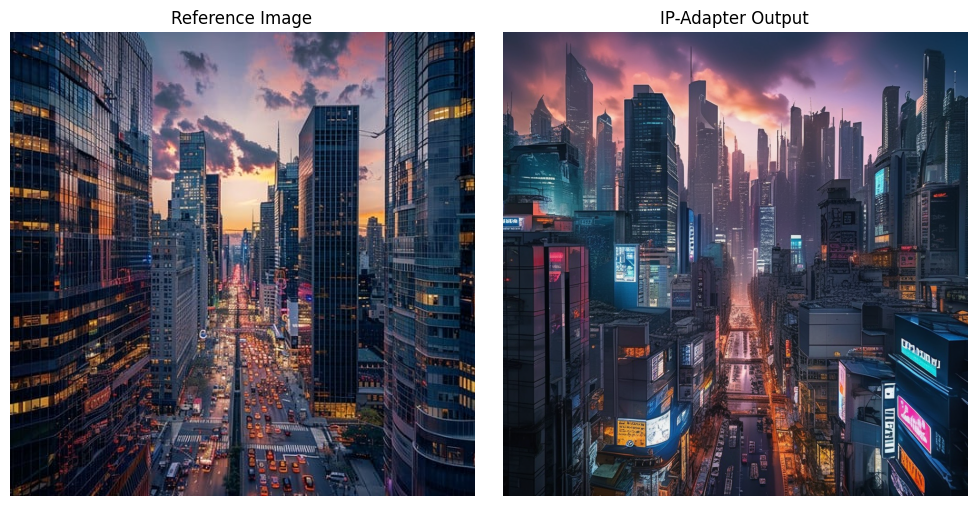

In [ ]:
pipe = setup_ip_adapter()
generate_with_ip_adapter(
    pipe,
    "city.jpg",
    "A cyberpunk city landscape"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

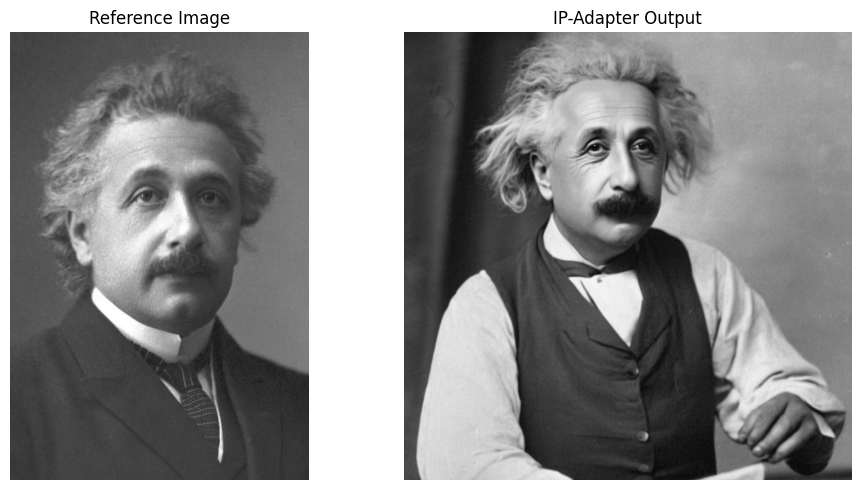

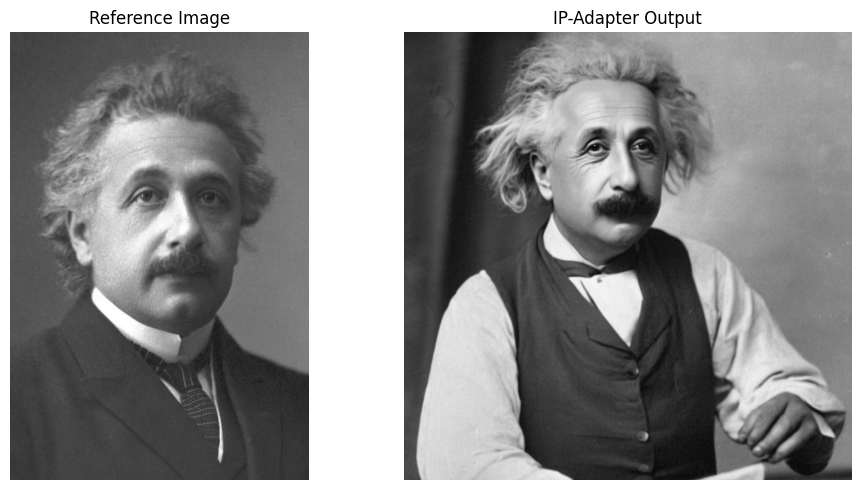

In [ ]:
pipe = setup_ip_adapter()
generate_with_ip_adapter(
    pipe,
    "ip_adapter_einstein_base.png",
    "A photo of Einstein as a chef, wearing an apron, cooking in a French restaurant"
)

#### 5. LoRA (Low-Rank Adaptation)

LoRA is an efficient fine-tuning method that updates only a small number of parameters.

The key idea is to represent weight updates as low-rank matrices:


$W' = W + \Delta W = W + BA$
where $B \in \mathbb{R}^{d×r}$, $A \in \mathbb{R}^{r×k}$, and typically $r \ll \min(d,k)$

Let's implement LoRA fine-tuning for Stable Diffusion:

In [12]:
from peft import LoraConfig, get_peft_model
import random
from tqdm import tqdm
from diffusers import UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch.nn.functional as F

In [1]:
def setup_lora_training():
    """Setup LoRA for fine-tuning Stable Diffusion with text conditioning"""
    # 1. Load the full Stable Diffusion pipeline first
    model_id = "runwayml/stable-diffusion-v1-5"
    pipeline = StableDiffusionPipeline.from_pretrained(
        model_id, 
        torch_dtype=torch.float16,
    )
    pipeline.to("cuda")
    
    # 2. Extract the individual components
    unet = pipeline.unet
    vae = pipeline.vae
    text_encoder = pipeline.text_encoder
    tokenizer = pipeline.tokenizer
    
    # 3. Configure LoRA for UNet
    lora_config = LoraConfig(
        r=8,  # rank
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        init_lora_weights="gaussian",
        lora_alpha=32,
        lora_dropout=0.1,
    )
    
    # 4. Wrap the UNet with LoRA (only UNet will be trained, text_encoder remains frozen)
    unet = get_peft_model(unet, lora_config)
    
    # 5. Set up optimizer and scheduler
    # Note: We're only optimizing the LoRA parameters, not the entire UNet
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=1e-4,
        weight_decay=1e-2,
    )
    
    # 6. Initialize noise scheduler
    noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
    
    return unet, vae, text_encoder, tokenizer, optimizer, noise_scheduler

def lora_training_loop_with_text(unet, vae, text_encoder, tokenizer, optimizer, 
                                 noise_scheduler, dataloader, num_epochs=100):
    """Implementation of the LoRA training loop with text conditioning"""
    # Move models to GPU and set to training mode
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16  # Use fp16 for all computations with models
    
    unet = unet.to(device)
    vae = vae.to(device)
    text_encoder = text_encoder.to(device)
    
    # Set models to appropriate modes
    unet.train()
    vae.eval()  # Freeze VAE
    text_encoder.eval()  # Freeze text encoder
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        for batch in tqdm(dataloader):
            # 1. Process batch data and prompts
            # Handle different data formats - single tensor or batch
            if isinstance(batch["pixel_values"], list):
                # Convert list to tensor if needed
                pixel_values = torch.stack(batch["pixel_values"]).to(device).to(dtype)
            else:
                pixel_values = batch["pixel_values"].to(device).to(dtype)
                
            # Ensure pixel_values has the right shape [batch_size, channels, height, width]
            if len(pixel_values.shape) == 3:  # [channels, height, width]
                pixel_values = pixel_values.unsqueeze(0)  # Add batch dimension
                
            prompts = batch["text"] if "text" in batch else [""] * len(pixel_values)
            if isinstance(prompts, str):
                prompts = [prompts]  # Convert single string to list
            
            # 2. Encode prompts
            with torch.no_grad():
                text_inputs = tokenizer(
                    prompts,
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                ).to(device)
                
                # Get text embeddings
                text_embeddings = text_encoder(text_inputs.input_ids)[0]
            
            # 3. Encode images to latent space (with no gradients for VAE)
            with torch.no_grad():
                # Scale down pixel values to [-1, 1] if needed
                if pixel_values.min() >= 0 and pixel_values.max() <= 1:
                    # Normalize from [0, 1] to [-1, 1]
                    pixel_values = 2.0 * pixel_values - 1.0
                    
                latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215
            
            # 4. Sample noise and timesteps
            batch_size = latents.shape[0]
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (batch_size,), device=device
            ).long()
            
            # 5. Add noise to the latents according to the noise magnitude at each timestep
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # 6. Predict noise residual with UNet conditioned on text embeddings
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
            
            # 7. Calculate loss
            loss = F.mse_loss(noise_pred, noise)
            
            # 8. Backpropagate and update
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.detach().item()
            
        # Print epoch stats
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}: Average Loss: {avg_loss:.4f}")
    
    # Save the LoRA weights
    unet.save_pretrained("lora_weights")
    return unet

def setup_text_conditioned_data(dataset_option="landscapes", image_size=512):
    """Prepare a dataset with text prompts for LoRA training
    
    Args:
        dataset_option: Which dataset to use
        image_size: Size to resize images to
    """
    # Dataset with prompts
    if dataset_option == "pokemon":
        try:
            # This dataset already has text captions
            dataset = load_dataset("lambdalabs/pokemon-blip-captions")
            caption_field = "text"
        except Exception as e:
            print(f"Error loading Pokemon dataset: {e}")
            dataset_option = "landscapes"  # Fall back to landscapes
    
    if dataset_option == "landscapes":
        # Creating generic captions for landscapes
        dataset = load_dataset("huggan/landscapes-v2", split="train[:1000]")
        
        # Add generic text descriptions
        landscape_prompts = [
            "a beautiful mountain landscape", 
            "a scenic view of mountains and sky",
            "a stunning landscape with mountains", 
            "a landscape with trees and mountains",
            "a beautiful nature landscape", 
            "a scenic vista with mountains",
            "a breathtaking view of the wilderness", 
            "a serene landscape scene"
        ]
        
        def add_landscape_captions(examples):
            examples["text"] = [
                random.choice(landscape_prompts) for _ in range(len(examples["image"]))
            ]
            return examples
        
        dataset = dataset.map(add_landscape_captions, batched=True)
        caption_field = "text"
        
    elif dataset_option == "watercolor":
        # Art dataset - watercolor paintings 
        dataset = load_dataset("Artificio/watercolor-art", split="train")
        
        # Add generic text descriptions
        watercolor_prompts = [
            "a watercolor painting of nature", 
            "a beautiful watercolor artwork",
            "an artistic watercolor scene", 
            "a colorful watercolor composition",
            "a delicate watercolor painting", 
            "a watercolor art piece"
        ]
        
        def add_watercolor_captions(examples):
            examples["text"] = [
                random.choice(watercolor_prompts) for _ in range(len(examples["img"]))
            ]
            return examples
        
        dataset = dataset.map(add_watercolor_captions, batched=True)
        caption_field = "text"
        
    elif dataset_option == "flowers":
        # Flowers dataset
        dataset = load_dataset("huggan/flowers-102-categories", split="train")
        print("Loaded flowers dataset")
        
        # Map numeric label to text
        # Prepare generic flower descriptions since we don't have label names
        flower_types = [
            "rose", "daisy", "sunflower", "tulip", "lily", "orchid", 
            "carnation", "daffodil", "peony", "chrysanthemum"
        ]
        
        def add_flower_captions(examples):
            # Since we don't have actual flower names, assign random flower types
            examples["text"] = [
                f"a photo of a {random.choice(flower_types)} flower" 
                for _ in range(len(examples["image"]))
            ]
            return examples
        
        dataset = dataset.map(add_flower_captions, batched=True)
        caption_field = "text"
    
    print(f"Dataset has {len(dataset)} training examples with text captions")
    
    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
    
    # Check if dataset has 'image' or 'img' field
    image_field = 'image' if 'image' in dataset.features else 'img'
    
    # Apply preprocessing
    def transform_images(examples):
        examples["pixel_values"] = [
            preprocess(image.convert("RGB")) 
            for image in examples[image_field]
        ]
        return examples
    
    # Apply transforms
    dataset = dataset.map(
        transform_images,
        batched=True,
        remove_columns=[image_field],  # Remove the raw image data
    )
    
    # Ensure the dataset keeps the text field
    columns_to_keep = ["pixel_values", caption_field]
    dataset = dataset.select_columns(columns_to_keep)
    
    # If the caption field isn't named "text", rename it
    if caption_field != "text":
        dataset = dataset.rename_column(caption_field, "text")
    
    # Define a custom dataset class to properly handle tensors
    class StableDiffusionDataset(torch.utils.data.Dataset):
        def __init__(self, hf_dataset):
            self.hf_dataset = hf_dataset
            
        def __len__(self):
            len_dataset = min(len(self.hf_dataset), 512)
            return len_dataset
        
        def __getitem__(self, idx):
            item = self.hf_dataset[idx]
            # Convert list to tensor if needed
            if isinstance(item["pixel_values"], list):
                item["pixel_values"] = torch.tensor(item["pixel_values"])
            return {
                "pixel_values": item["pixel_values"],
                "text": item["text"]
            }
    
    # Create custom dataset and dataloader
    custom_dataset = StableDiffusionDataset(dataset)
    dataloader = DataLoader(
        custom_dataset,
        batch_size=4,
        shuffle=True,
    )
    
    return dataloader

In [ ]:
dataloader = setup_text_conditioned_data(dataset_option="flowers")
unet, vae, text_encoder, tokenizer, optimizer, noise_scheduler = setup_lora_training()
trained_unet = lora_training_loop_with_text(
    unet, vae, text_encoder, tokenizer, optimizer, 
    noise_scheduler, dataloader, num_epochs=5
)

Loaded flowers dataset
Dataset has 8189 training examples with text captions


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  2%|▏         | 32/2048 [01:45<1:48:28,  3.23s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f53ebe34e90>>
Traceback (most recent call last):
  File "/home/jovyan/.mlspace/envs/dgm/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
  2%|▏         | 37/2048 [02:00<1:46:49,  3.19s/it]